In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re 
from collections import Counter
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords , wordnet
from nltk.stem import WordNetLemmatizer 
from nltk import pos_tag
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer , CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold , cross_val_score
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImpbPipeline
import joblib

In [108]:
# Download Required NLTK data
nltk.download('punkt' , quiet=True)
nltk.download('stopwords' , quiet=True)
nltk.download('wordnet' , quiet =True)
nltk.download('omw-1.4' , quiet= True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)

True

#  Enhanced Text Preprocessing 

In [109]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J') :
        return wordnet.ADJ
    elif treebank_tag.startswith('V') :
        return wordnet.VERB
    elif treebank_tag.startswith('N') :
        return wordnet.NOUN
    elif treebank_tag.startswith('R') :
        return wordnet.ADV
    else :
        return wordnet.NOUN

### 1.Load Data

In [110]:
column_names = ['tweet_id', 'entity', 'sentiment', 'tweet_content']
df_train = pd.read_csv('twitter_training.csv', names=column_names)
df_val = pd.read_csv('twitter_validation.csv', names=column_names)

print("Training Data Info:")
df_train.info()
print("\nTraining Data Head:")
print(df_train.head())

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet_id       74682 non-null  int64 
 1   entity         74682 non-null  object
 2   sentiment      74682 non-null  object
 3   tweet_content  73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB

Training Data Head:
   tweet_id       entity sentiment  \
0      2401  Borderlands  Positive   
1      2401  Borderlands  Positive   
2      2401  Borderlands  Positive   
3      2401  Borderlands  Positive   
4      2401  Borderlands  Positive   

                                       tweet_content  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i wi

### 2- NLP Processing 

In [111]:
def extract_hashtags_mentions(text):
    if pd.isna(text):
        return [] , []
    hashtags = re.findall(r"#(\w+)" , text)
    mentions = re.findall(r"@(\w+)" , text)
    return hashtags , mentions

def clean_text(text) : 
    if pd.isna(text) : 
        return ""
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+', '', text)  # remove mentions
    text = re.sub(r'#\w+', '', text)  # remove hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # keep only letters and spaces
    return ' '.join(text.split())  # normalize whitespace

tokenizer = TweetTokenizer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_tweet(text , lemmatizer , tokenizer , stop_words):
    hashtags , mentions = extract_hashtags_mentions(text)
    cleaned = clean_text(text)
    if not cleaned.strip():
        return "" , hashtags , mentions
    tokens = tokenizer.tokenize(cleaned.lower())
    pos_tags = pos_tag(tokens)
    lemmatized = []
    for word , tag in pos_tags:
        if word not in stop_words and len(word) > 2 : 
            wn_tags = get_wordnet_pos(tag)
            lemma = lemmatizer.lemmatize(word , wn_tags)
            lemmatized.append(lemma) 
    return ' '.join(lemmatized) , hashtags , mentions

print("Preprocessing Training Set...")
preprocessed_train = df_train['tweet_content'].apply(lambda x: preprocess_tweet(x,lemmatizer , tokenizer , stop_words))
df_train['clean_text'] = preprocessed_train.apply(lambda x:x[0])
df_train['hashtags'] = preprocessed_train.apply(lambda x:x[1])
df_train['mentions'] = preprocessed_train.apply(lambda x:x[2])
df_train = df_train[df_train['clean_text'].str.len() > 0].reset_index(drop = True)
print(f"Remaning tweets after preprocessing : {len(df_train)}")

print("Preprocessing Validation Set...")
preprocessed_val = df_val['tweet_content'].apply(lambda x: preprocess_tweet(x,lemmatizer , tokenizer , stop_words))
df_val['clean_text'] = preprocessed_val.apply(lambda x:x[0])
df_val['hashtags'] = preprocessed_val.apply(lambda x:x[1])
df_val['mentions'] = preprocessed_val.apply(lambda x:x[2])
df_val = df_val[df_val['clean_text'].str.len() > 0].reset_index(drop = True)
print(f"Remaning tweets after preprocessing : {len(df_val)}")

Preprocessing Training Set...
Remaning tweets after preprocessing : 72188
Preprocessing Validation Set...
Remaning tweets after preprocessing : 999


### 3-Missing values detection 

In [112]:
print("Missing values before cleaning:")
print(df_train.isnull().sum())
df_train.dropna(subset=['tweet_content'], inplace=True)
n_duplicates = df_train.duplicated(subset=['tweet_content']).sum()
print(f"\nNumber of duplicate rows found: {n_duplicates}")
df_train.drop_duplicates(subset = ['tweet_content'],inplace=True)
print(f"Total rows after cleaning (dropped missing and duplicates): {len(df_train)}")

Missing values before cleaning:
tweet_id         0
entity           0
sentiment        0
tweet_content    0
clean_text       0
hashtags         0
mentions         0
dtype: int64

Number of duplicate rows found: 3164
Total rows after cleaning (dropped missing and duplicates): 69024


### 4- Sentiment Distribution

C:\Users\omarb\AppData\Local\Temp\ipykernel_12820\3504143724.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='sentiment', data=df_train, order=df_train['sentiment'].value_counts().index, palette='viridis')


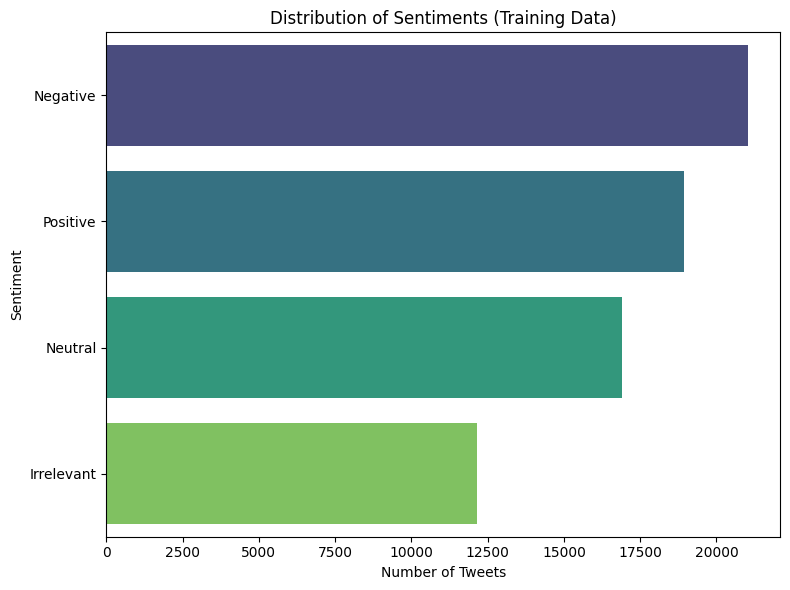

In [113]:
plt.figure(figsize=(8, 6))
sns.countplot(y='sentiment', data=df_train, order=df_train['sentiment'].value_counts().index, palette='viridis')
plt.title('Distribution of Sentiments (Training Data)')
plt.xlabel('Number of Tweets')
plt.ylabel('Sentiment')
plt.tight_layout()
plt.savefig('sentiment_distribution.png')
plt.show()
plt.close()

### 5- Entity Distribution
#### Get value counts for entities and select the top 20

C:\Users\omarb\AppData\Local\Temp\ipykernel_12820\1684225633.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='entity', data=df_train, order=top_entities, palette='plasma')


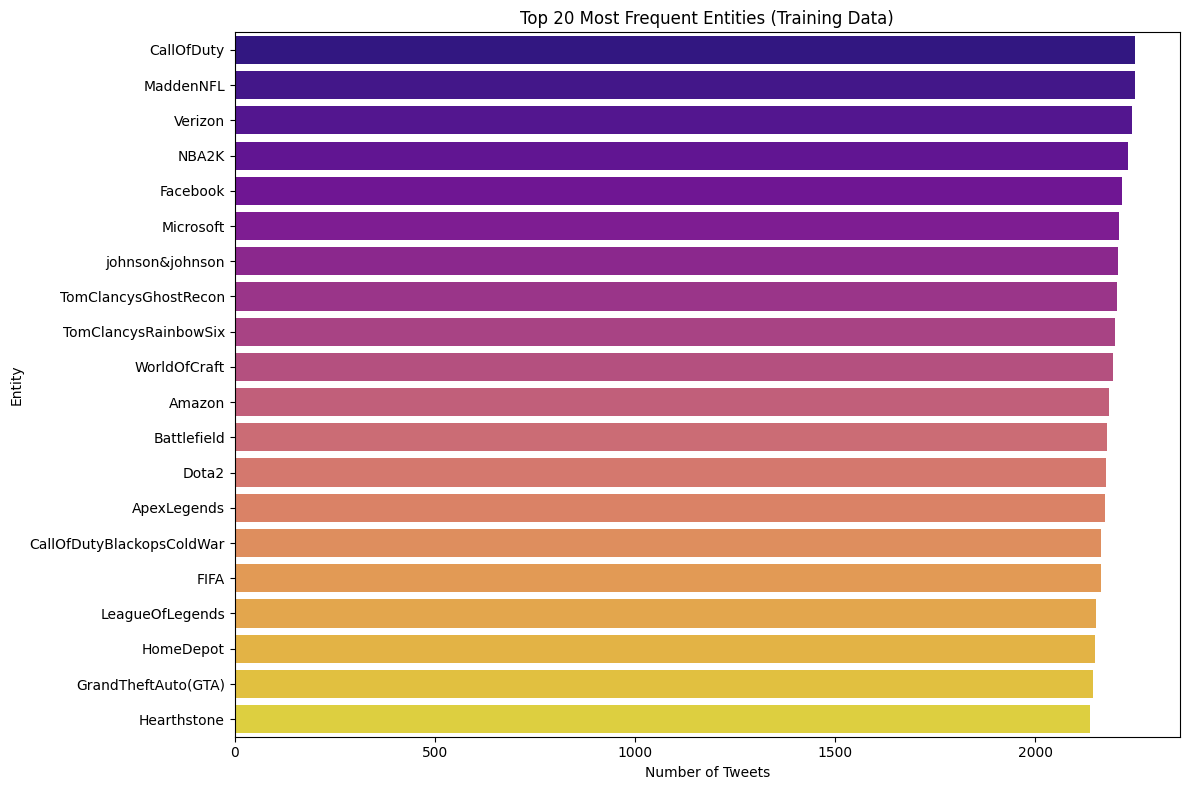

In [114]:
plt.figure(figsize=(12, 8))

top_entities = df_train['entity'].value_counts().head(20).index
sns.countplot(y='entity', data=df_train, order=top_entities, palette='plasma')
plt.title('Top 20 Most Frequent Entities (Training Data)')
plt.xlabel('Number of Tweets')
plt.ylabel('Entity')
plt.tight_layout()
plt.savefig('entity_distribution.png')
plt.show()
plt.close()

### 6-Bivariate Analysis: Sentiment by Entity

<Figure size 1200x800 with 0 Axes>

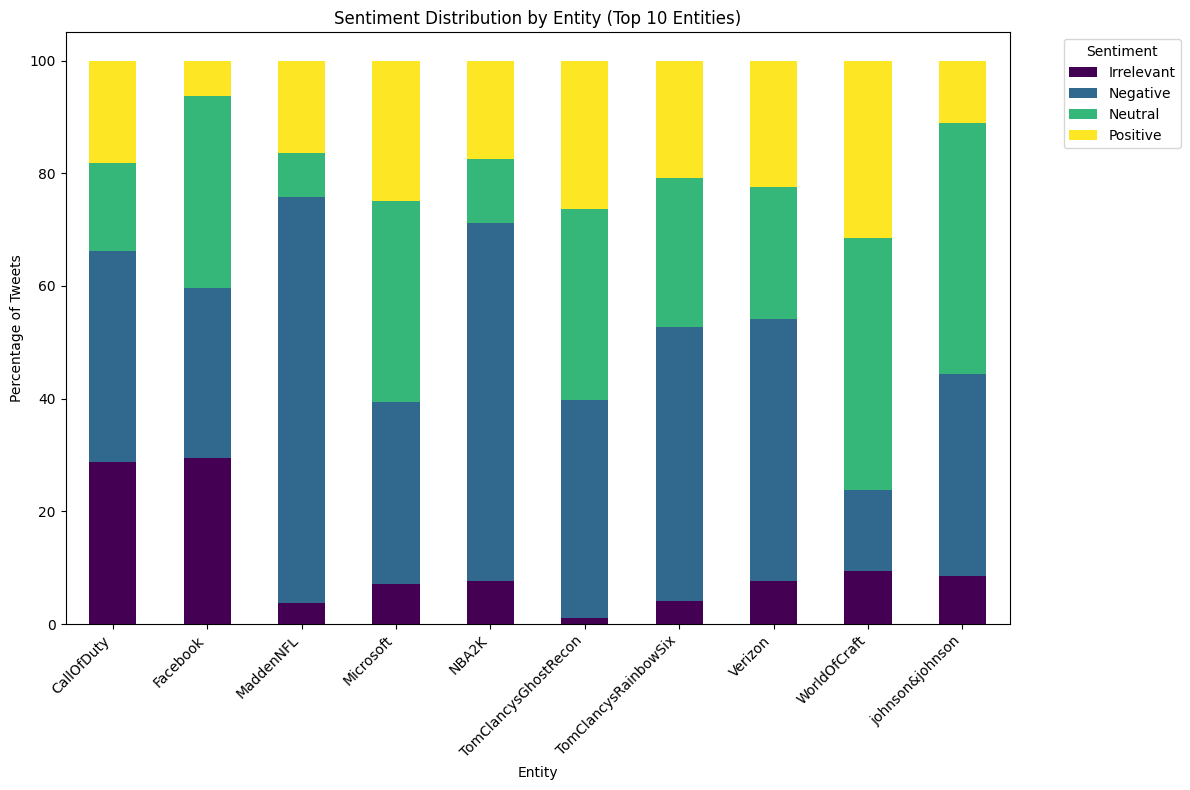

In [115]:
# 1-Sentiment Distribution per Entity
# 2-Create a cross-tabulation table
# 3-Plot the stacked bar chart 

top_10_entities = df_train['entity'].value_counts().head(10).index
df_top_10 = df_train[df_train['entity'].isin(top_10_entities)]
sentiment_by_entity = pd.crosstab(df_top_10['entity'], df_top_10['sentiment'], normalize='index') * 100

plt.figure(figsize=(12, 8))
sentiment_by_entity.plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 8))
plt.title('Sentiment Distribution by Entity (Top 10 Entities)')
plt.xlabel('Entity')
plt.ylabel('Percentage of Tweets')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('sentiment_by_entity.png')
plt.show()
plt.close()

### 7- Basic Text Analysis

Tweet Length Descriptive Statistics:
count    69024.000000
mean       113.510243
std         78.045216
min          3.000000
25%         52.000000
50%         95.000000
75%        157.000000
max        957.000000
Name: tweet_length, dtype: float64


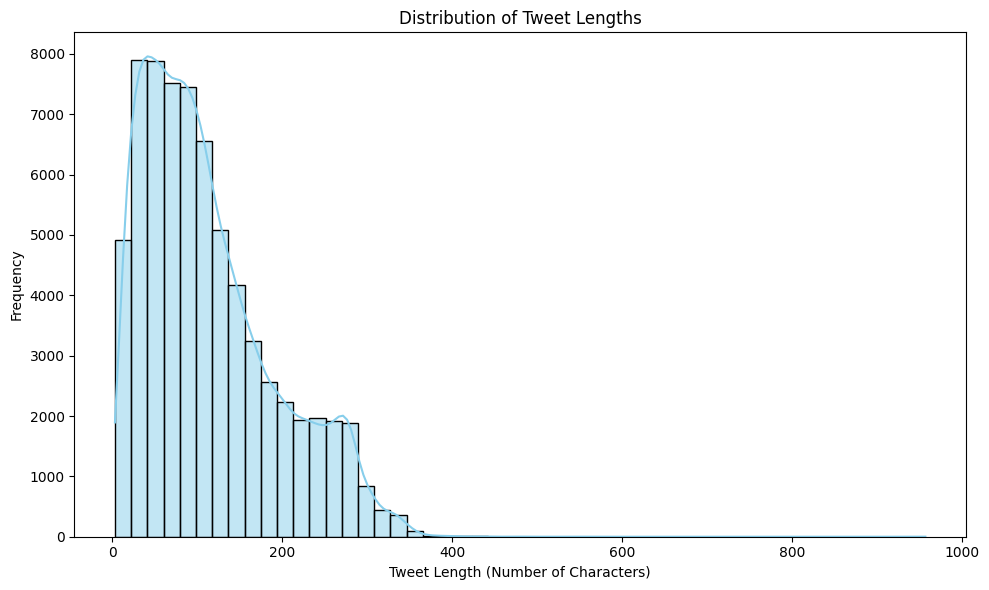

In [116]:
# 1- Descriptive statistics for tweet length
# 2-Plot the distribution of tweet lengths
df_train['tweet_length'] = df_train['tweet_content'].apply(len)

print("Tweet Length Descriptive Statistics:")
print(df_train['tweet_length'].describe())
plt.figure(figsize=(10, 6))
sns.histplot(df_train['tweet_length'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length (Number of Characters)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('tweet_length_distribution.png')
plt.show()
plt.close()


Plotting n-gram for : Positive


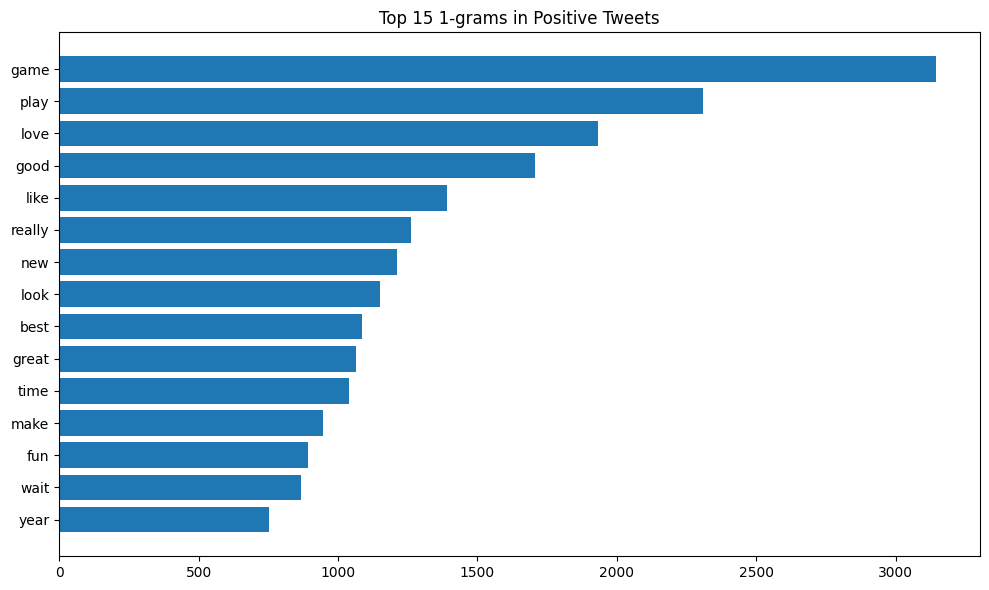

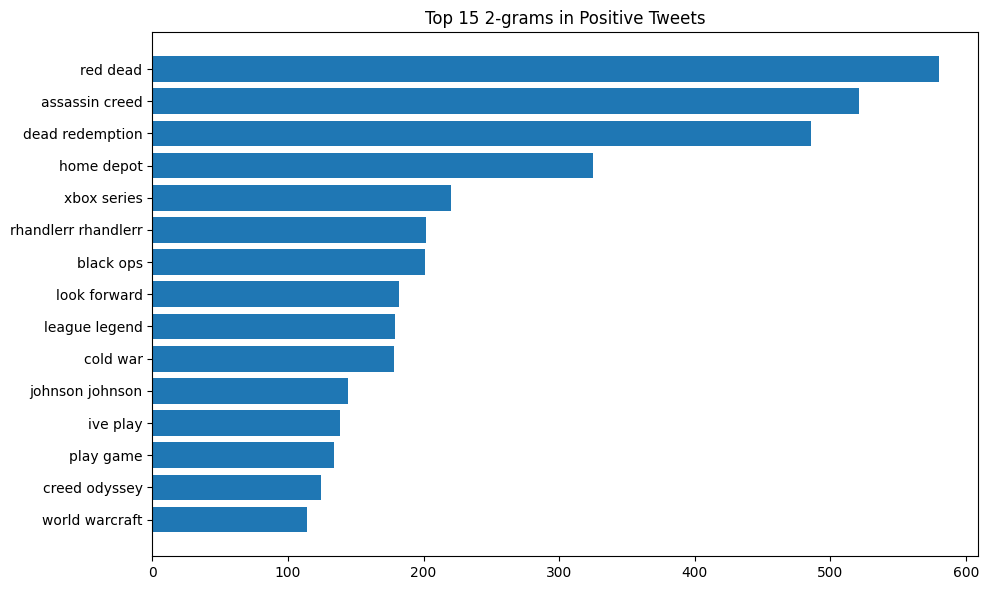

Plotting n-gram for : Neutral


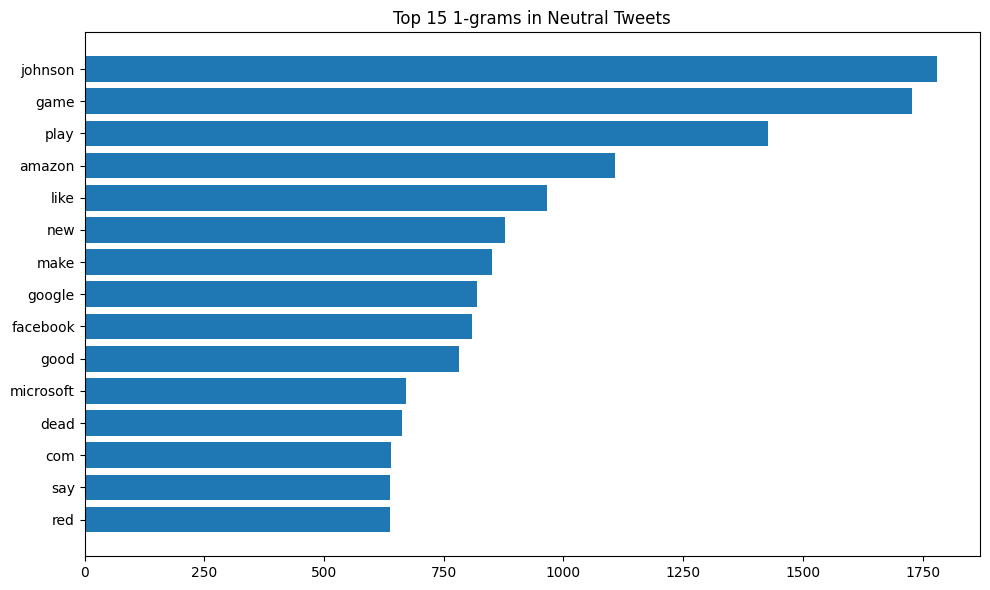

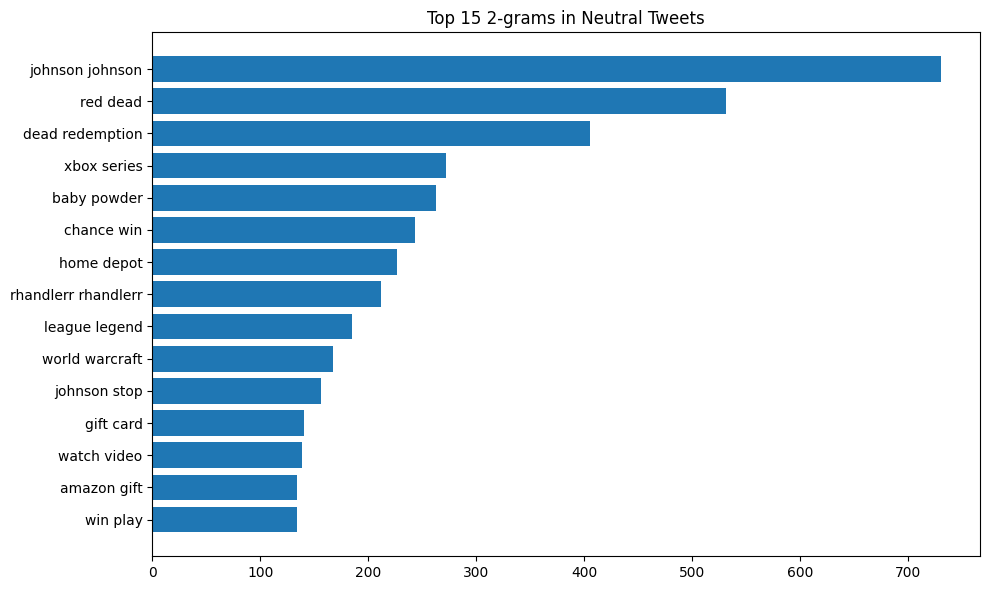

Plotting n-gram for : Negative


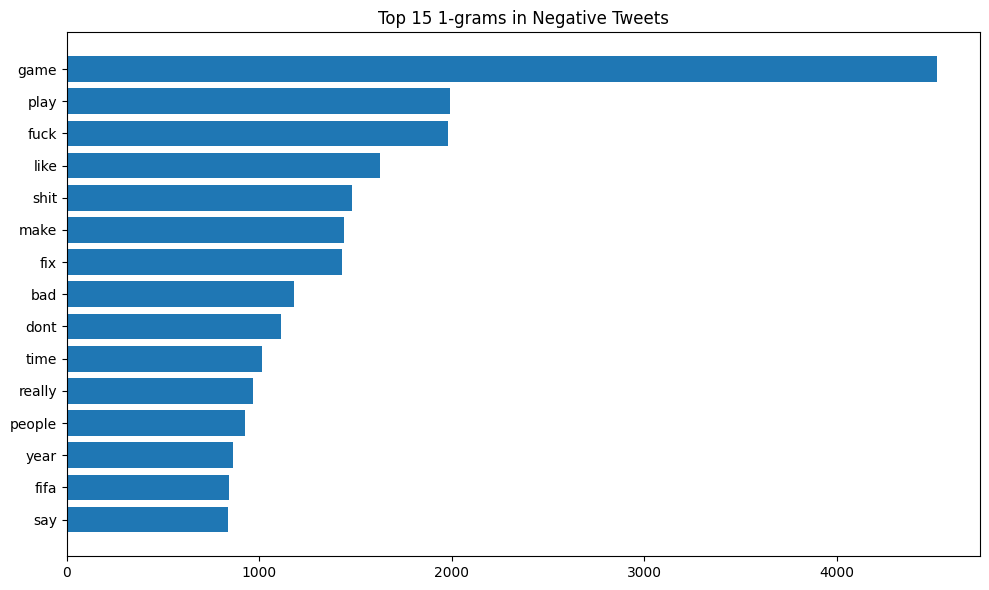

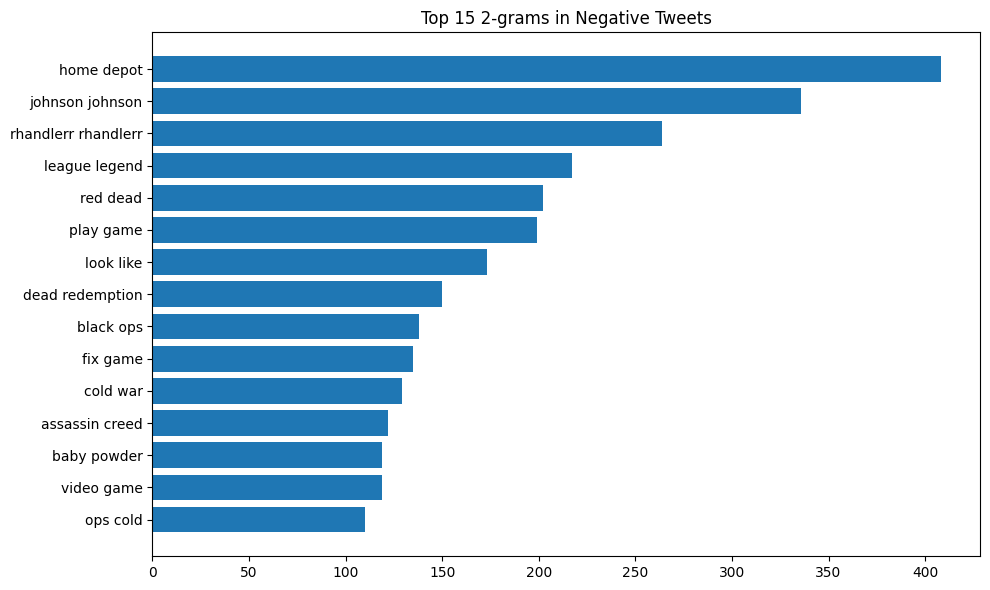

Plotting n-gram for : Irrelevant


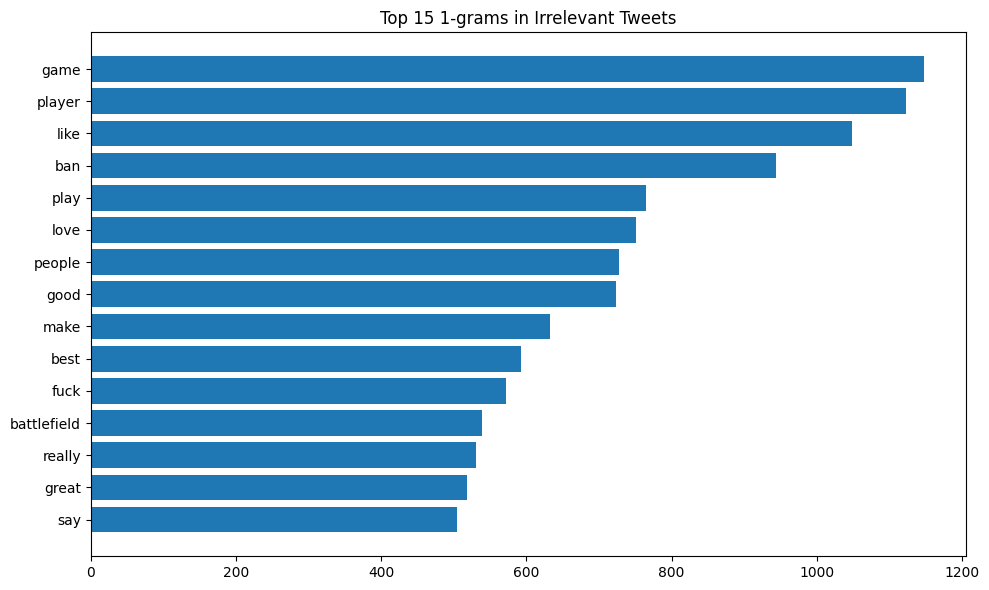

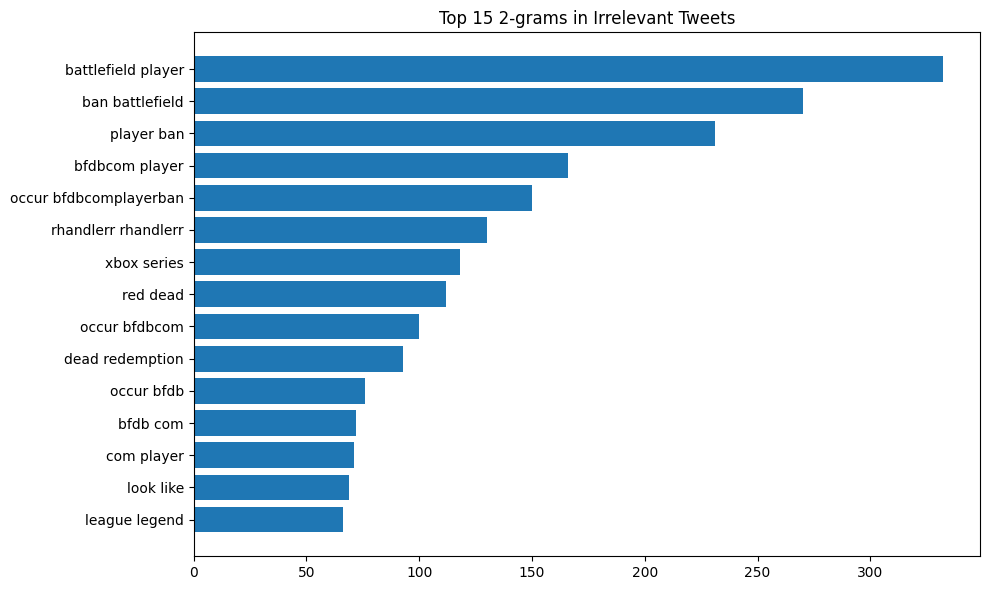

In [117]:
# Word and N-Gram Analystics 
def plot_top_ngrams(sentiment_class , ngram_range = (1,1) , top_k = 15) : 
    texts = df_train[df_train['sentiment'] == sentiment_class]['clean_text']
    if texts.empty: 
        return
    vec = CountVectorizer(ngram_range = ngram_range , stop_words = 'english' , min_df = 5 , max_features = 10000)
    X_counts = vec.fit_transform(texts)
    freqs = np.array(X_counts.sum(axis = 0)).flatten()
    ngrams = vec.get_feature_names_out()
    top_idx = freqs.argsort()[-top_k:][::-1]

    plt.figure(figsize=(10,6))
    plt.barh(range(len(top_idx)) , freqs[top_idx])
    plt.yticks(range(len(top_idx)) , [ngrams[i] for i in top_idx])
    plt.gca().invert_yaxis()
    ngram_label = f"{ngram_range[0]}-gram" if ngram_range[0] == ngram_range[1] else f"{ngram_range[0]}-{ngram_range[1]}-gram"
    plt.title(f'Top {top_k} {ngram_label}s in {sentiment_class} Tweets')
    plt.tight_layout()
    plt.savefig(f"top_{ngram_range[0]}_{ngram_range[1]}grams_{sentiment_class.lower()}.png")
    plt.show()
    plt.close()

for sentiment in df_train['sentiment'].unique() : 
    print(f"Plotting n-gram for : {sentiment}")
    plot_top_ngrams(sentiment , ngram_range=(1,1) , top_k = 15)
    plot_top_ngrams(sentiment , ngram_range=(2,2) , top_k = 15)

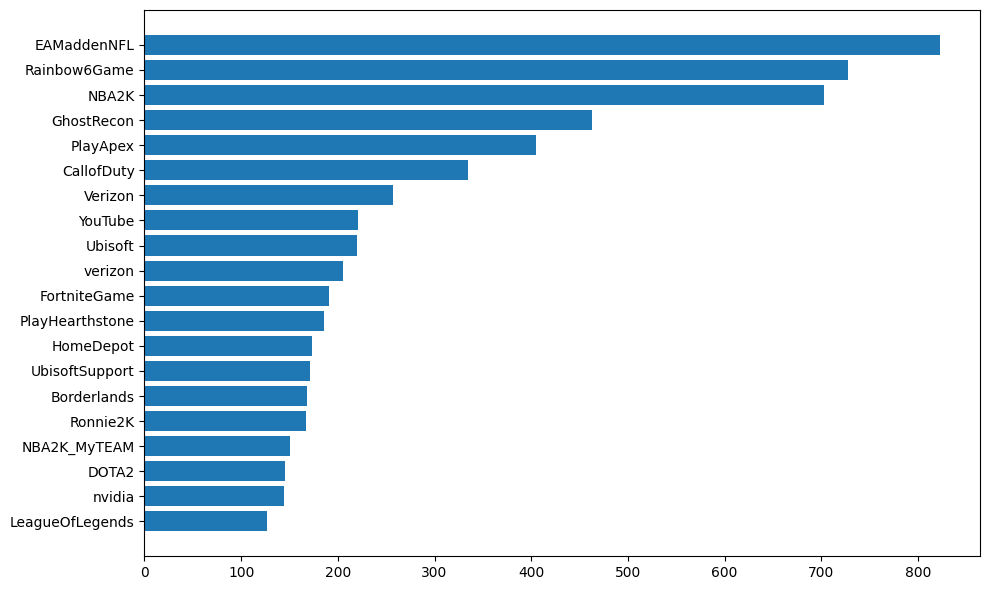

In [118]:
# Top mentioned users overall 
all_mentions = [mention for mentions in df_train['mentions'] for mention in mentions]
top_mentions = Counter(all_mentions).most_common(20)

plt.figure(figsize=(10,6))
names , counts = zip(*top_mentions)
plt.barh(range(len(names)) , counts)
plt.yticks(range(len(names)) , names)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('top_mentions.png')
plt.show()

### Supervised Learning 

In [ ]:
X_train = df_train["clean_text"]
y_train = df_train["sentiment"]

# Predict on validation set
X_val = df_val['clean_text']
y_val = df_val['sentiment']

# Biseline : Logistic Regression 
lr_pipeline = Pipeline([
    ('tfidf' , TfidfVectorizer(ngram_range=(1,1) , max_features=10000 , stop_words = 'english' , sublinear_tf= True , min_df = 2)),
    ('clf' , LogisticRegression(random_state= 42 , max_iter=1000 , class_weight= 'balanced'))
])

# Random Forest with (1,2) grams 
rf_pipeline = Pipeline([
    ('tfidf' , TfidfVectorizer(ngram_range=(1,2) , max_features=10000 , stop_words = 'english' , sublinear_tf= True , min_df = 2)),
    ('clf' , RandomForestClassifier(n_estimators=100 , random_state=42 , class_weight= 'balanced' , n_jobs=1))
])

# Support vector machine  
svm_pipeline = Pipeline([
    ('tfidf' , TfidfVectorizer(ngram_range=(1,2) , max_features=10000 , stop_words = 'english' , sublinear_tf= True , min_df = 2)),
    ('clf' , SVC(kernel='linear' , random_state=42 , class_weight='balanced'))
])

# Evaluate 
skf = StratifiedKFold(n_splits=5 , shuffle=True , random_state=42 )
models = {'Logistic Regression' : lr_pipeline , 'Random Forest' : rf_pipeline , 'Support vector machine' : svm_pipeline}
results = {}

for name , pipe in models.items() : 
    scores = cross_val_score(pipe , X_train , y_train , cv = skf , scoring= 'accuracy' , n_jobs= 1)
    results[name] = scores.mean()
    print(f"{name} -> {scores.mean():.4f} ± {scores.std()*2:.4}")

# Train best model 
best_name = max(results , key = results.get)
best_model = models[best_name]
print(f"Best model among all of them is -> {best_model} , and the accurecy is -> {results[best_name]:.4f}")
best_model.fit(X_train,y_train) 

y_val_pred = best_model.predict(X_val)

# Save Model 
joblib.dump(best_model , 'best_sentiment_classifier.pkl')
print("Model Saved !")


print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred)) 

Logistic Regression -> 0.7158 ± 0.009423
Random Forest -> 0.8829 ± 0.003026
Support vector machine -> 0.7500 ± 0.006702
Best model among all of them is -> Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=10000, min_df=2,
                                 ngram_range=(1, 2), stop_words='english',
                                 sublinear_tf=True)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', n_jobs=1,
                                        random_state=42))]) , and the accurecy is -> 0.8829
Model Saved !
Validation Accuracy: 0.9610

Validation Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.93      0.97      0.95       172
    Negative       0.97      0.97      0.97       265
     Neutral       0.97      0.94      0.96       285
    Positive       0.96      0.98      0.97       277

    accuracy                           0.96       999
   macro avg       0.96      0.96